# Lab 1 Spark implementation

### TEAM F
Chouliarias Andreas 2143

Matzoros Christos-Konstantinos 2169

Pappas Apostolos 2109

The section bellow imports the winequality-red.csv dataset that is about red wines. It is implemented in IBM Watson Studio.

In [164]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-0b9a0e48-0866-409f-ba74-68779995a703',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'sdZ8O2iAAR3wmataGXBRlupSSvC59vNRURnzhD6yJvjn'
}

configuration_name = 'os_42ab0f413afd4dafbd1616d8723b81bc_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('winequality-red.csv', 'sparkinmachinelearning-donotdelete-pr-cm2t5jr1q3edzz'))

We will select 'fixed acidity' and 'pH' features to implement the linear regression.

In [165]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql import types 
from pyspark.sql.functions import rand 

data = df_data_1.select([c for c in df_data_1.columns if c in ['fixed acidity','pH']])

data = data.withColumn("fixed acidity", data["fixed acidity"].cast("double"))
data = data.withColumn("pH", data["pH"].cast("double"))

We prepare our dataframe to fit in our model.

In [166]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['fixed acidity'], outputCol = 'features')
data = vectorAssembler.transform(data)
data = data.select(['features', 'pH'])

We split our dataframe to train set and test set with ratios 70-30 %.

In [167]:
train, test = data.randomSplit([0.7, 0.3], seed=1)

train = train.orderBy(rand())
test = test.orderBy(rand())

We construct our Linear Regression model.<br> We train the model with the train set and we print:<br> The Coefficients, The Intercept, The MSE and The $R^2$.

In [168]:
lr = LinearRegression(featuresCol = 'features', labelCol='pH')
lr_model = lr.fit(train)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("MSE: %f" % trainingSummary.meanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [-0.0587359790593]
Intercept: 3.801089734458954
MSE: 0.012421
r2: 0.464073


We use the test set to make the predictions that we will later use to plot the regression line.

In [169]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test)
predictions.select("prediction","pH","features").show(5)

+------------------+----+--------+
|        prediction|  pH|features|
+------------------+----+--------+
|3.4545474580089937| 3.5|   [5.9]|
| 3.413432272667473| 3.4|   [6.6]|
|3.2430979333954584|3.18|   [9.5]|
| 3.407558674761541|3.39|   [6.7]|
|3.3958114789496783|3.22|   [6.9]|
+------------------+----+--------+
only showing top 5 rows



We transform our data to numpy arrays to make the plot

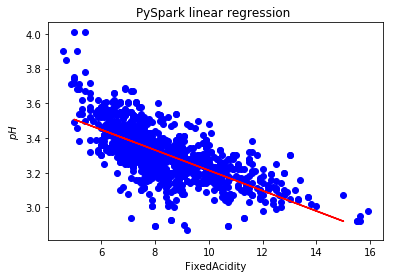

In [170]:
import numpy as np

trainX=np.array(train.select('features').collect()).reshape(-1, 1) 
trainY=np.array(train.select('pH').collect()).reshape(-1, 1) 
test=np.array(test.select('features').collect()).reshape(-1, 1) 
predictions=np.array(predictions.select('prediction').collect()).reshape(-1, 1) 

plt.plot(trainX, trainY ,'bo')
plt.plot(test, predictions, "r-")
plt.xlabel(r'FixedAcidity')
plt.ylabel(r'$pH$')
plt.title(r'PySpark linear regression ')
plt.show()

The plot depicts with red the regression line.<br>
The plot depicts with blue dots each instance of the dataset.